In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
# Custom Grid World Environment
class GridWorldEnv(gym.Env):
    def __init__(self, grid_size=5):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.observation_space = gym.spaces.Box(low=0, high=grid_size - 1, shape=(2,), dtype=np.int32)  # Agent (x, y)
        self.action_space = gym.spaces.Discrete(4)  # Up, Down, Left, Right
        self.start_pos = np.array([0, 0])
        self.goal_pos = np.array([grid_size - 1, grid_size - 1])
        self.obstacle_pos = np.array([[1, 1], [2, 2], [3, 1]])  # Example obstacles

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = self.start_pos.copy()
        return self.agent_pos, {}

    def step(self, action):
        if action == 0:  # Up
            new_pos = self.agent_pos + np.array([0, 1])
        elif action == 1:  # Down
            new_pos = self.agent_pos + np.array([0, -1])
        elif action == 2:  # Left
            new_pos = self.agent_pos + np.array([-1, 0])
        elif action == 3:  # Right
            new_pos = self.agent_pos + np.array([1, 0])

        if np.any(new_pos < 0) or np.any(new_pos >= self.grid_size) or np.any(np.all(new_pos == self.obstacle_pos, axis=1)):
            reward = -1  # Penalty for hitting a wall or obstacle
            terminated = False
        else:
            self.agent_pos = new_pos
            if np.all(self.agent_pos == self.goal_pos):
                reward = 10  # Reward for reaching the goal
                terminated = True
            else:
                reward = -0.1 # Small negative reward for each step
                terminated = False

        truncated = False
        return self.agent_pos, reward, terminated, truncated, {}

    def render(self, mode='human'):
        grid = np.zeros((self.grid_size, self.grid_size))
        grid[self.agent_pos[1], self.agent_pos[0]] = 1  # Agent
        grid[self.goal_pos[1], self.goal_pos[0]] = 2  # Goal
        for obs in self.obstacle_pos:
          grid[obs[1], obs[0]] = -1 # Obstacles
        plt.imshow(grid, cmap='viridis')
        plt.title("Grid World")
        plt.pause(0.1)  # Pause for visualization
        plt.clf() # Clear the figure for the next frame

In [3]:
# Hyperparameters
gamma = 0.99  # Discount factor
lr_actor = 0.001  # Actor learning rate
lr_critic = 0.001  # Critic learning rate
clip_ratio = 0.2  # PPO clip ratio
epochs = 10  # Number of optimization epochs
batch_size = 64  # Batch size for optimization

In [7]:
# Actor and Critic networks
class ActorCritic(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.policy_logits = tf.keras.layers.Dense(action_size)
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.value = tf.keras.layers.Dense(1)

    def call(self, state):
        x = self.dense1(state)
        logits = self.policy_logits(x)
        value = self.value(x)
        return logits, value

In [5]:
# PPO algorithm
def ppo_loss(old_logits, old_values, advantages, states, actions, returns):
    def compute_loss(logits, values, actions, returns):
        actions_onehot = tf.one_hot(actions, action_size, dtype=tf.float32)
        policy = tf.nn.softmax(logits)
        action_probs = tf.reduce_sum(actions_onehot * policy, axis=1)
        old_policy = tf.nn.softmax(old_logits)
        old_action_probs = tf.reduce_sum(actions_onehot * old_policy, axis=1)

        # Policy loss
        ratio = tf.exp(tf.math.log(action_probs + 1e-10) - tf.math.log(old_action_probs + 1e-10))
        clipped_ratio = tf.clip_by_value(ratio, 1 - clip_ratio, 1 + clip_ratio)
        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))

        # Value loss
        value_loss = tf.reduce_mean(tf.square(values - returns))

        # Entropy bonus (optional)
        entropy_bonus = tf.reduce_mean(policy * tf.math.log(policy + 1e-10))

        total_loss = policy_loss + 0.5 * value_loss - 0.01 * entropy_bonus  # Entropy regularization
        return total_loss

    def get_advantages(returns, values):
        advantages = returns - values
        return (advantages - tf.reduce_mean(advantages)) / (tf.math.reduce_std(advantages) + 1e-8)

    def train_step(states, actions, returns, old_logits, old_values):
        with tf.GradientTape() as tape:
            logits, values = model(states)
            loss = compute_loss(logits, values, actions, returns)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    advantages = get_advantages(returns, old_values)
    for _ in range(epochs):
        loss = train_step(states, actions, returns, old_logits, old_values)
    return loss

In [9]:
# Environment setup
env = GridWorldEnv(grid_size=5)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [10]:
# Initialize actor-critic model and optimizer
model = ActorCritic(state_size, action_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_actor)

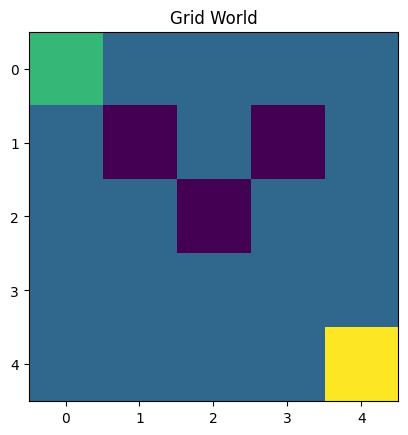

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'actor_critic', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


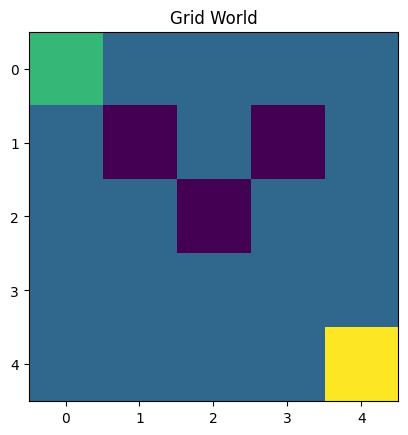

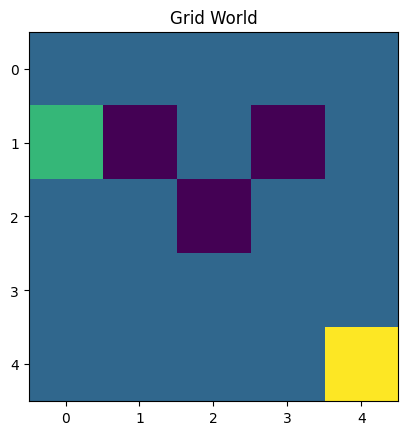

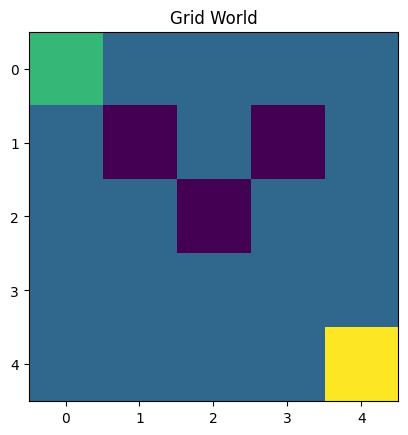

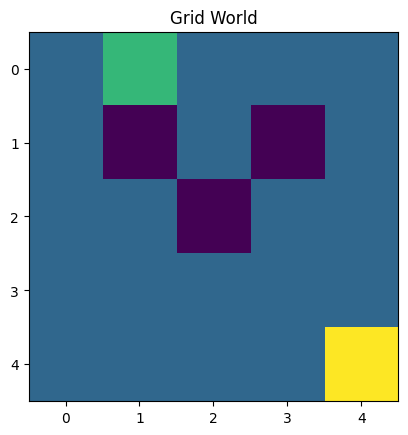

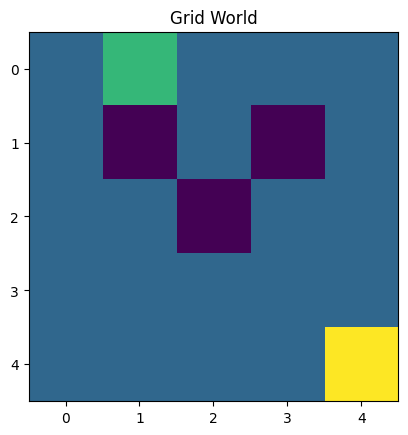

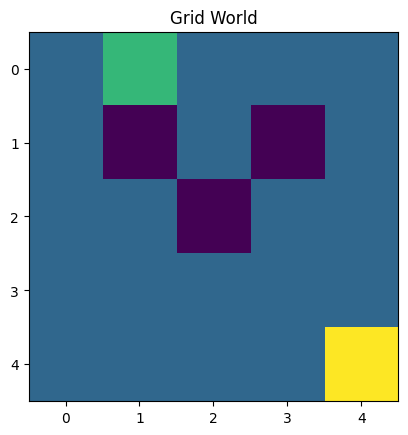

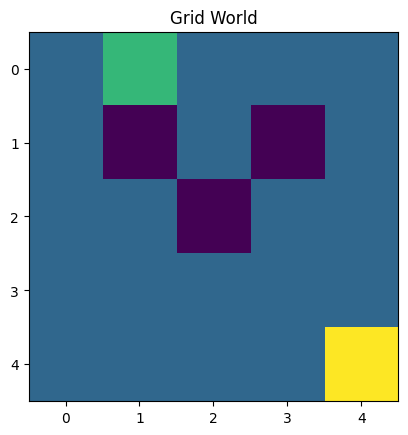

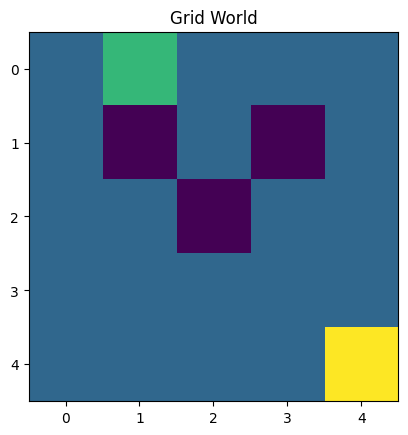

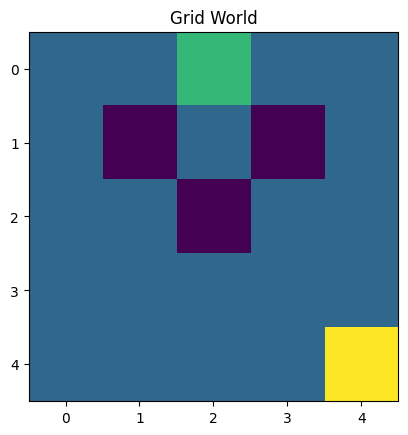

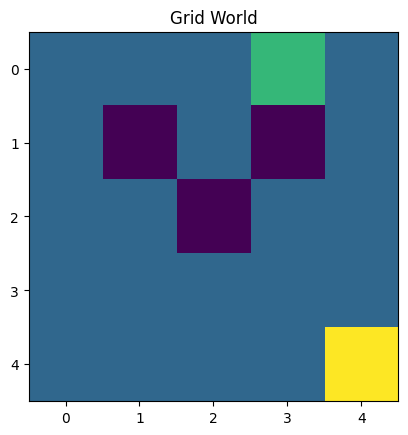

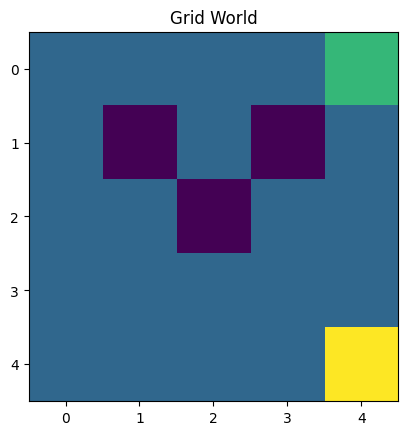

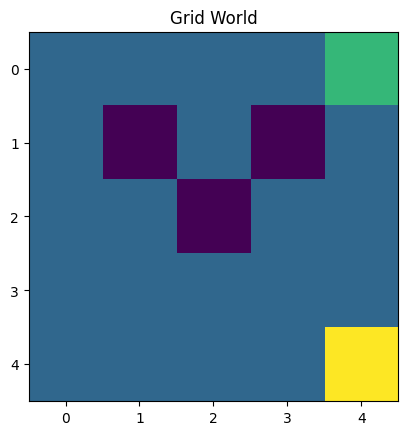

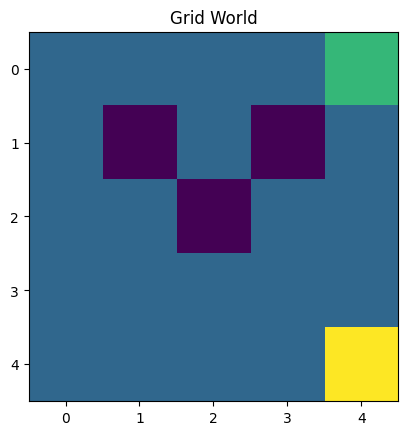

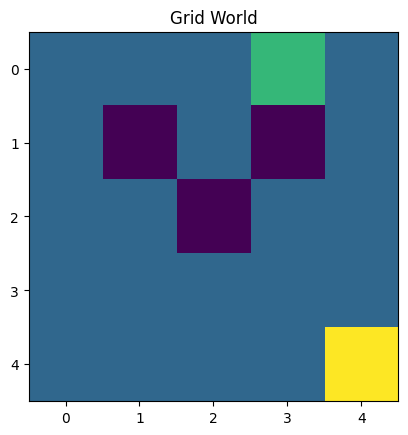

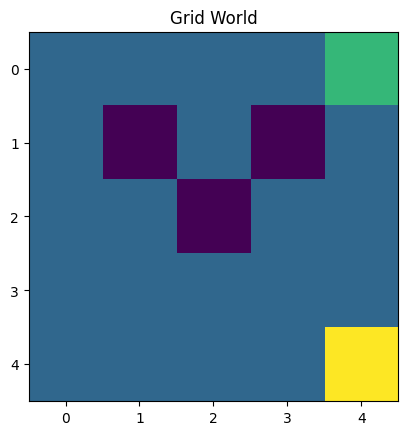

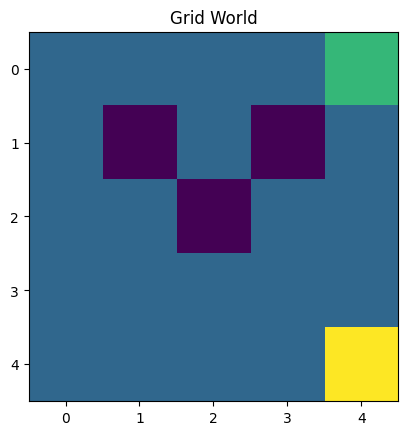

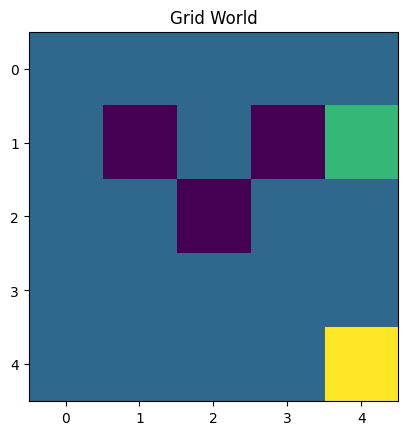

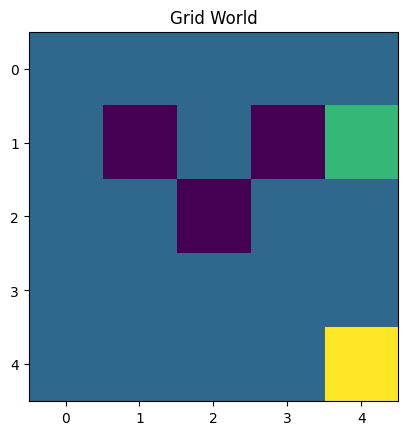

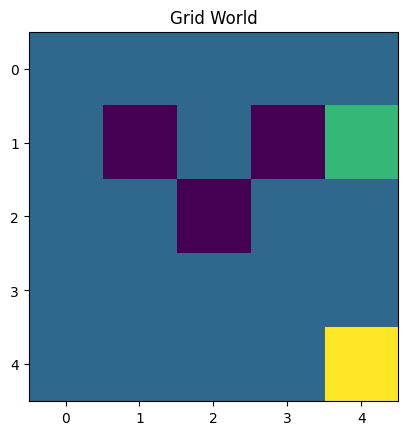

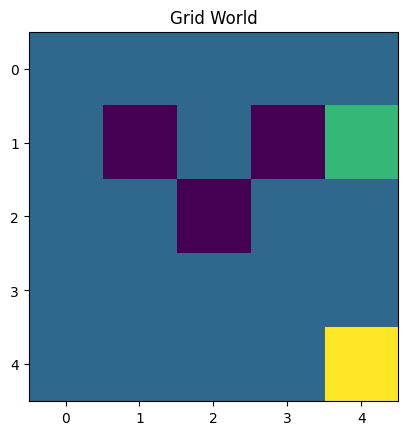

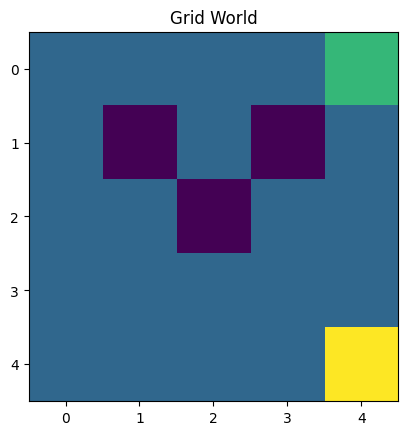

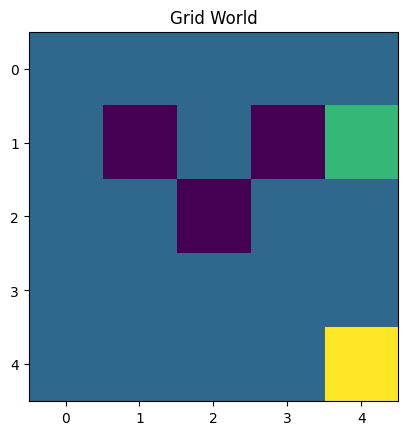

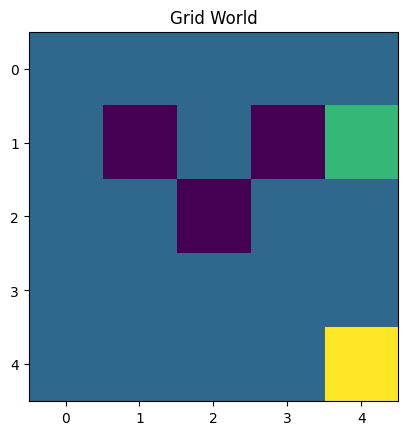

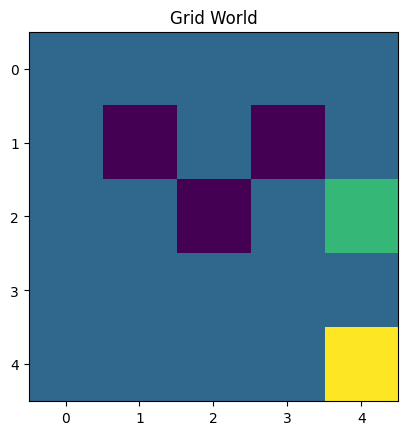

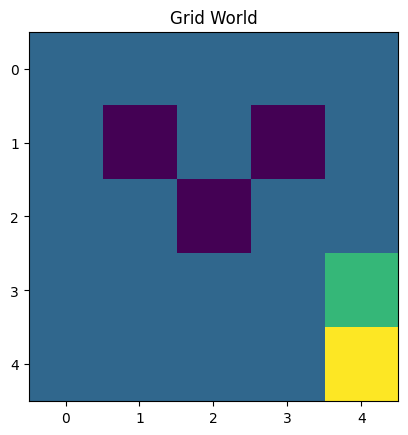

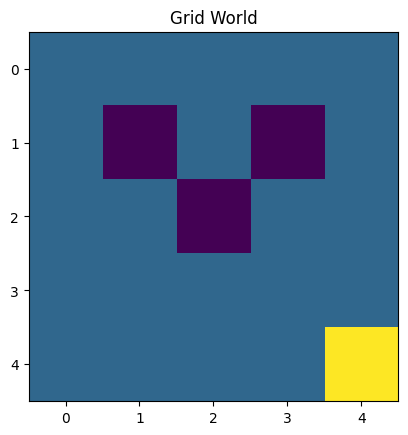

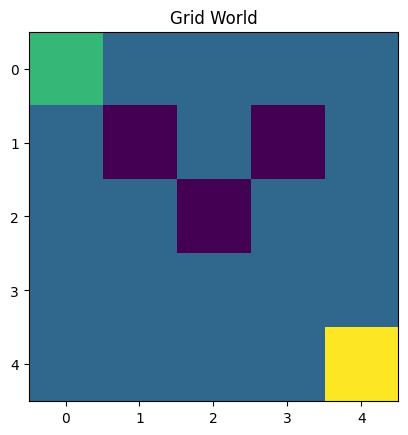

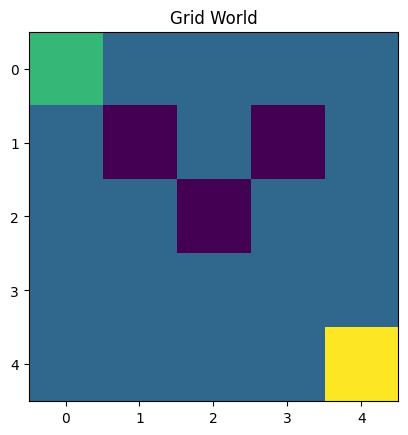

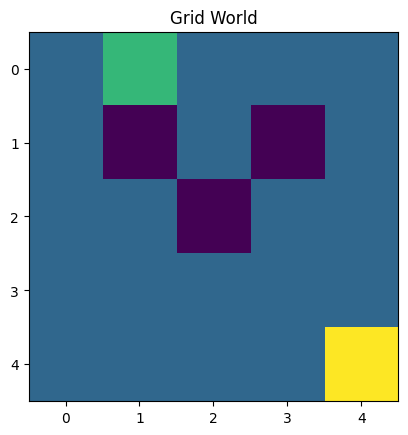

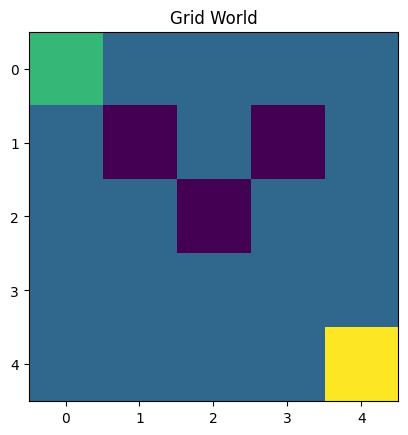

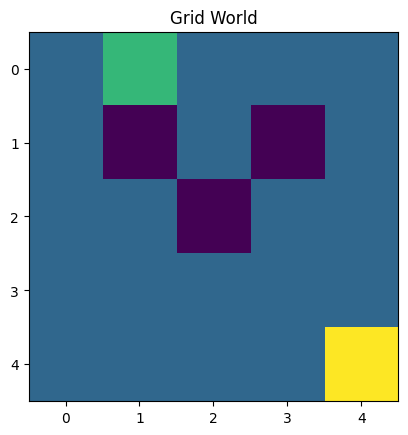

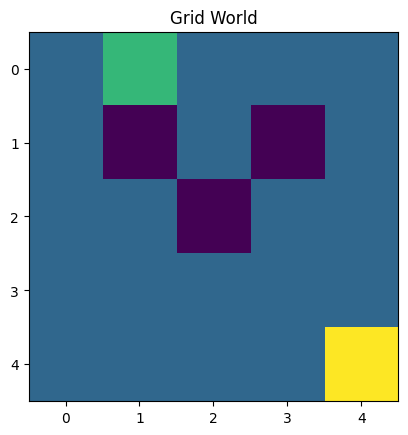

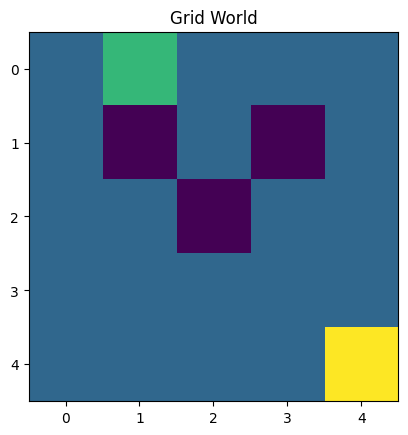

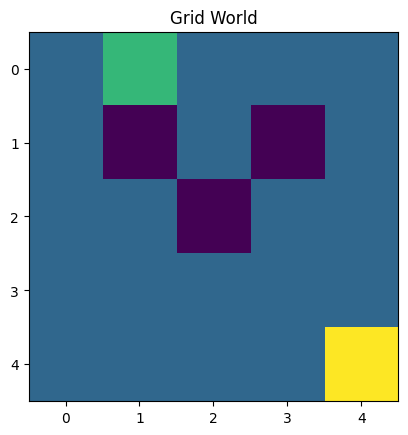

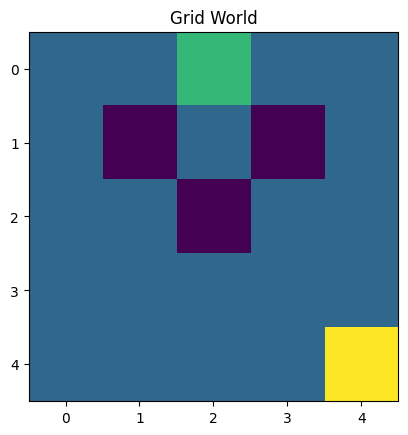

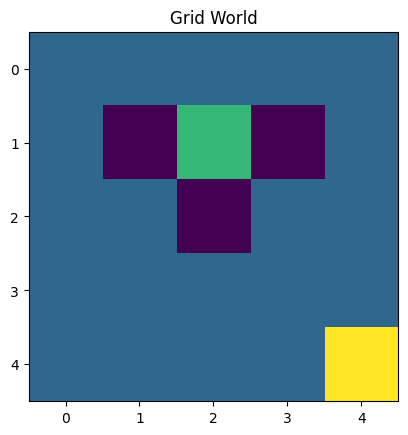

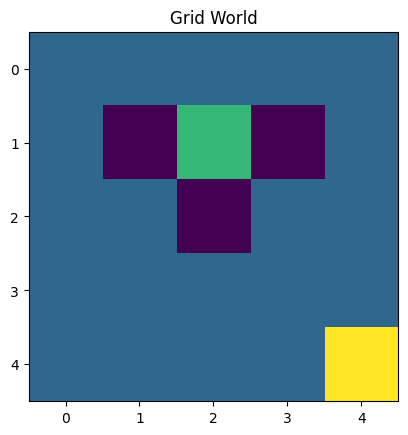

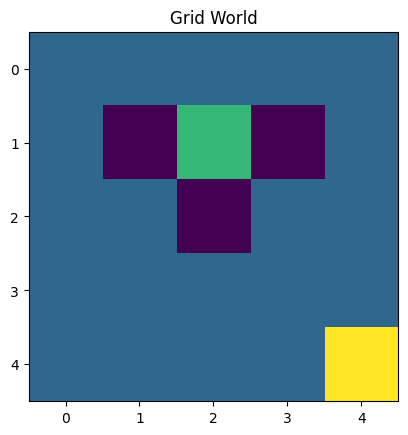

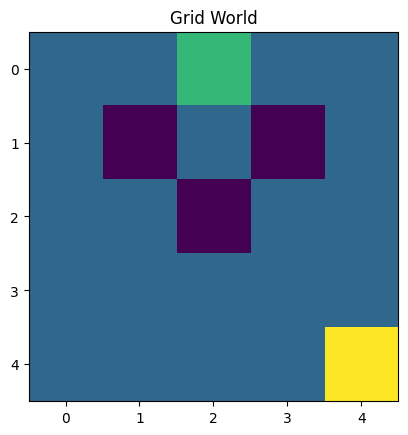

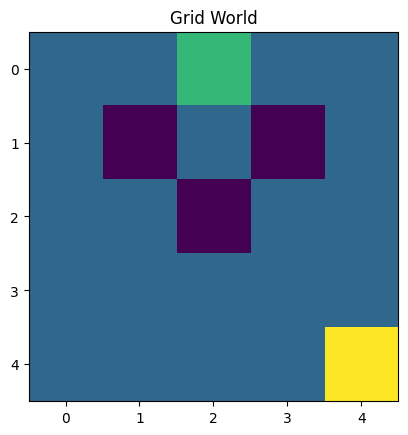

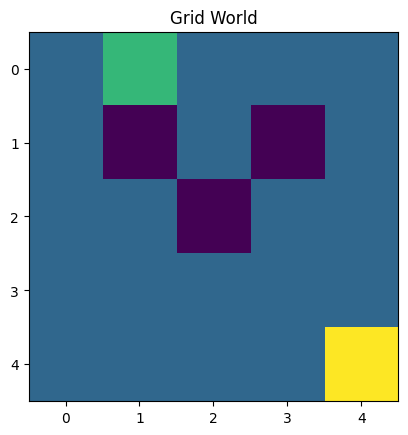

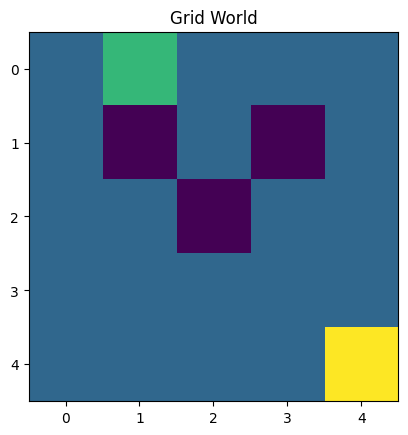

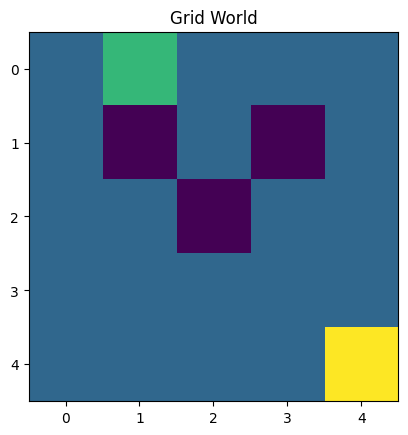

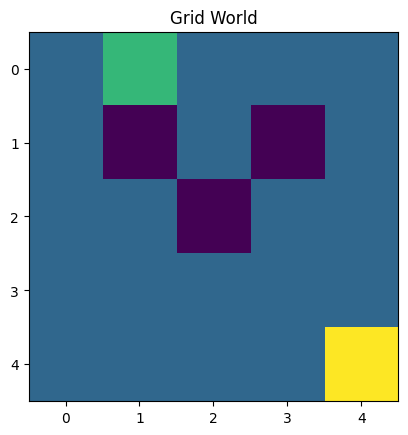

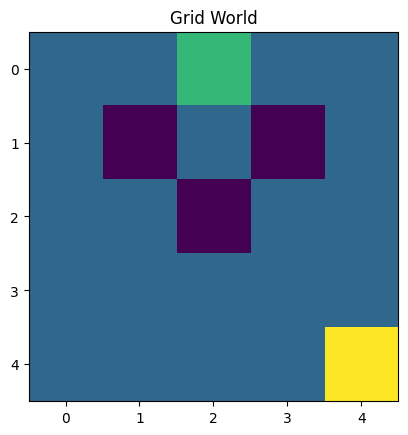

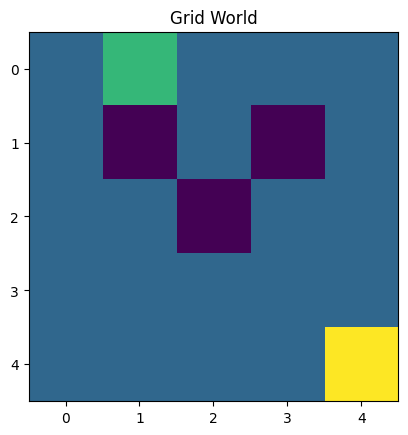

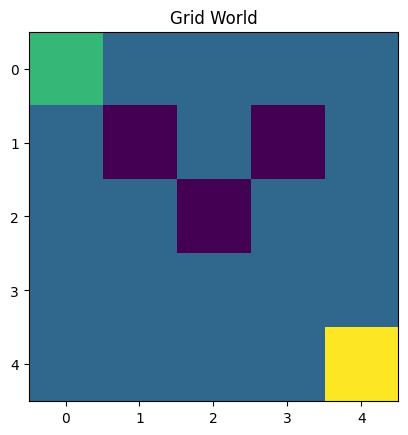

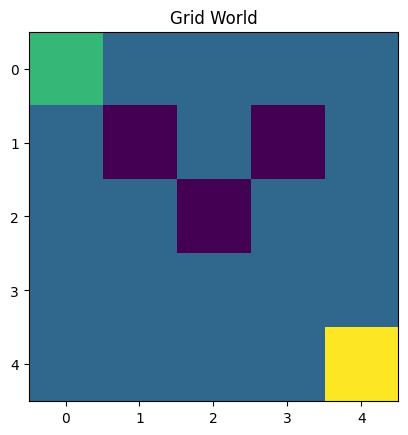

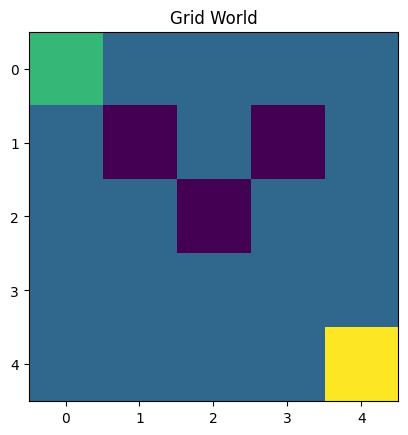

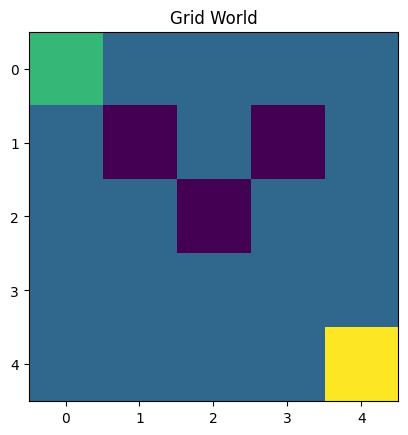

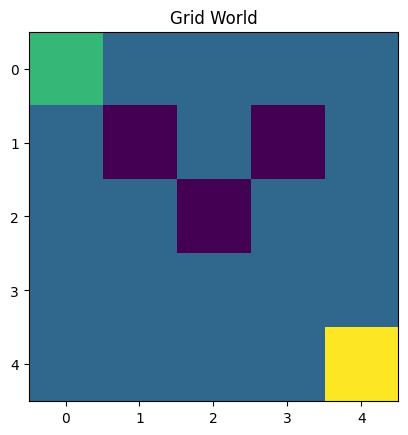

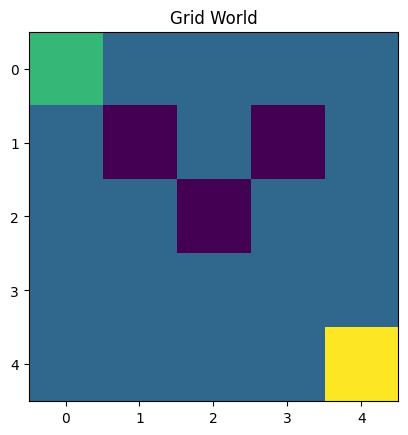

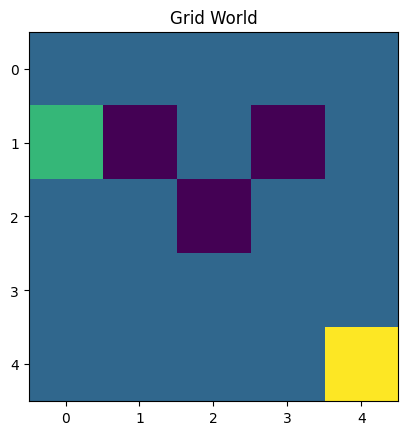

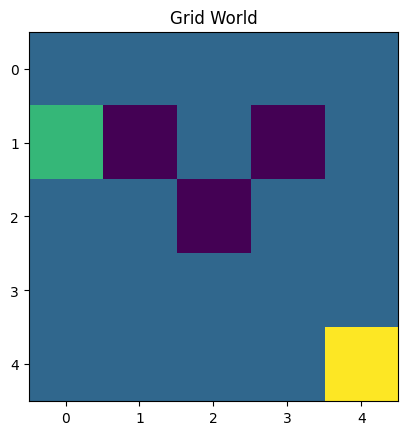

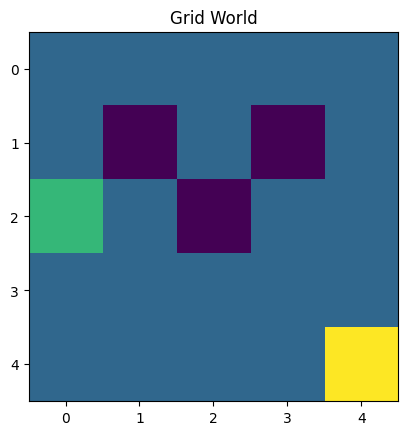

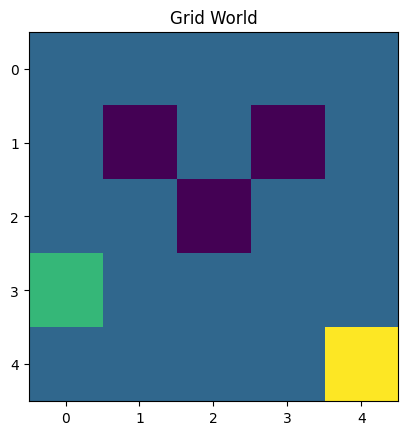

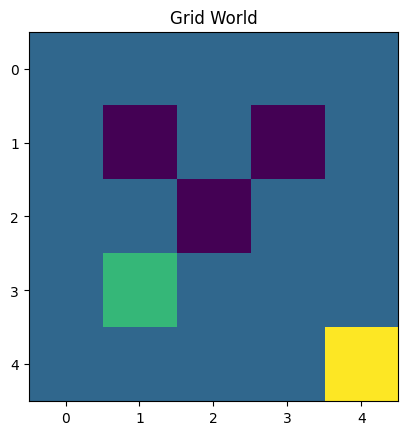

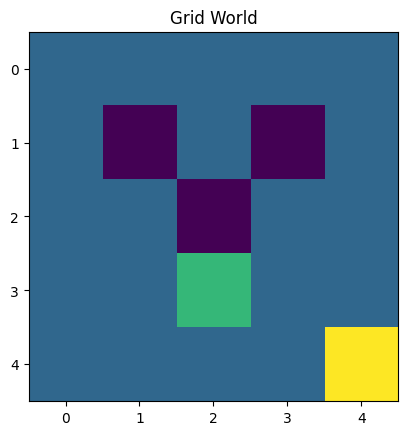

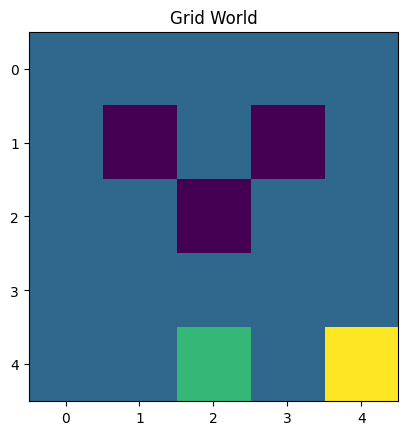

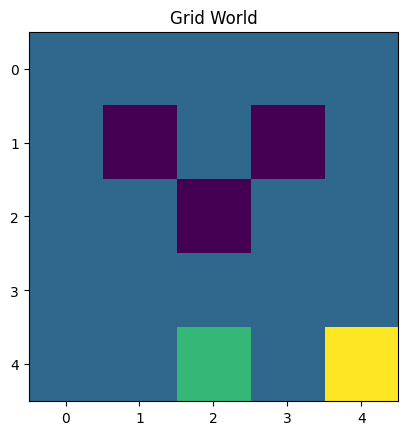

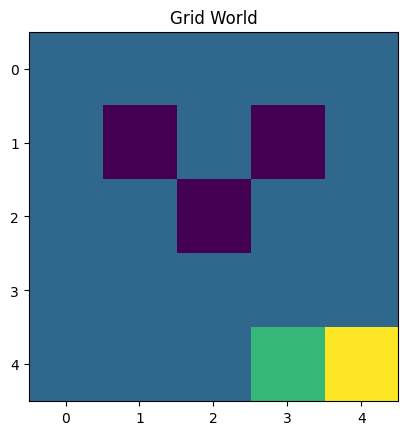

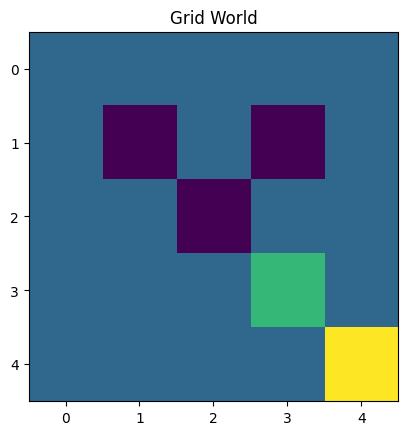

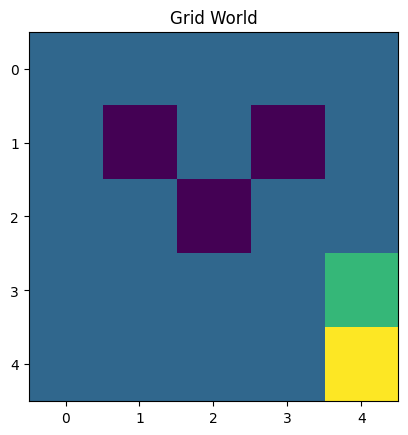

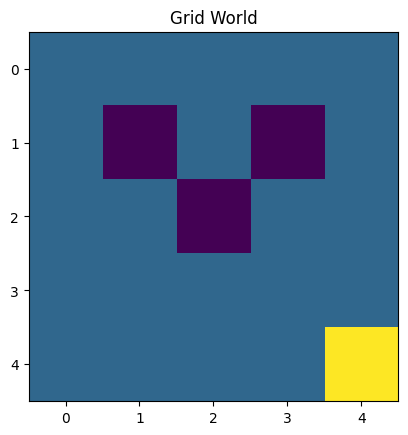

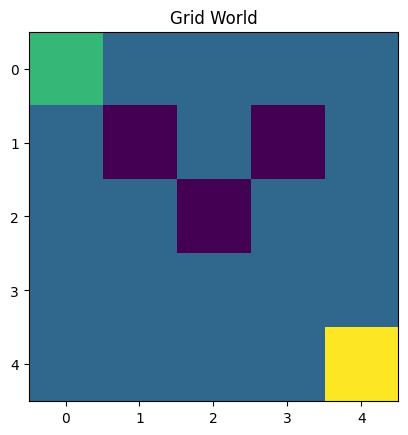

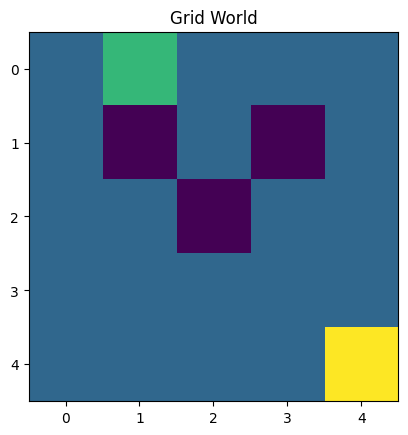

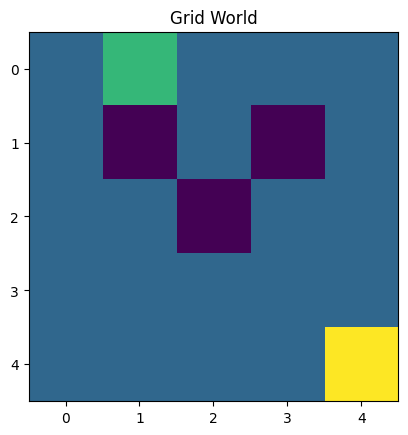

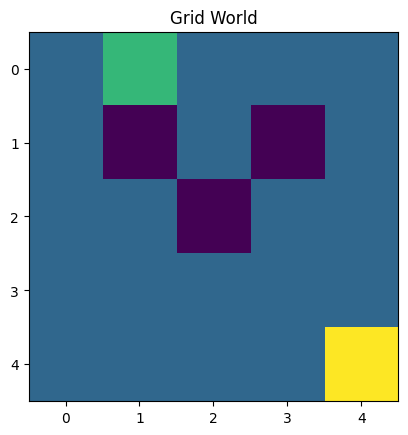

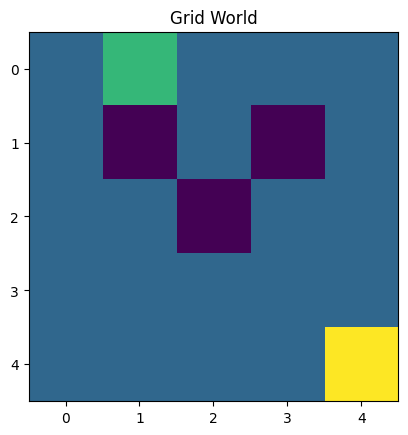

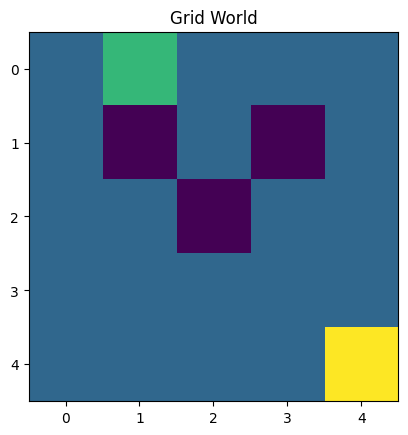

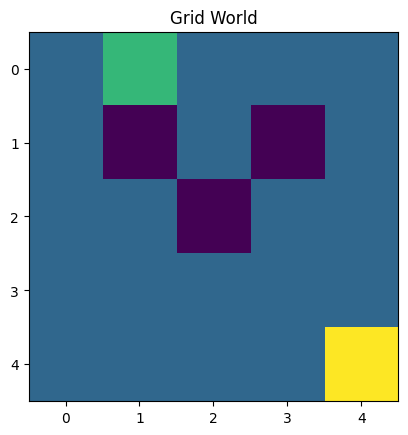

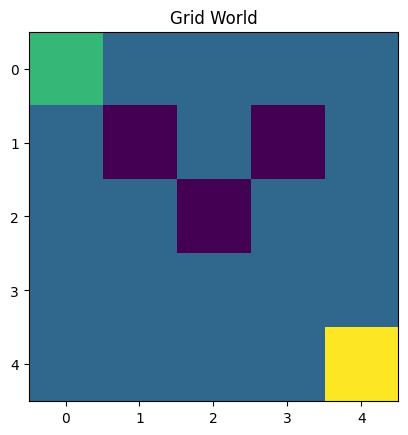

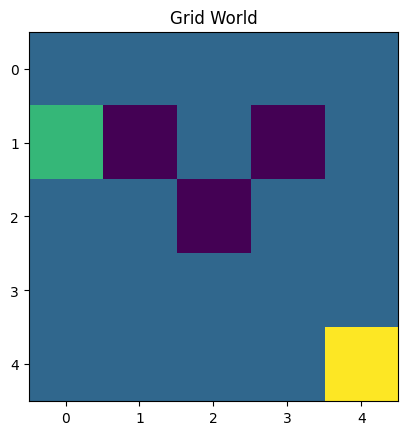

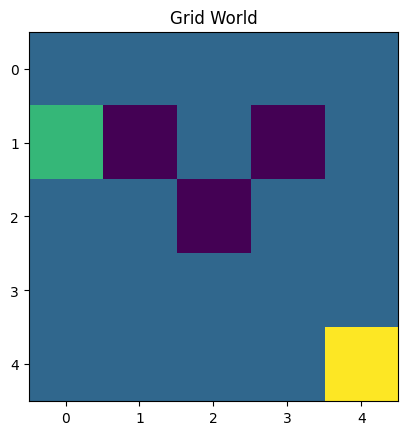

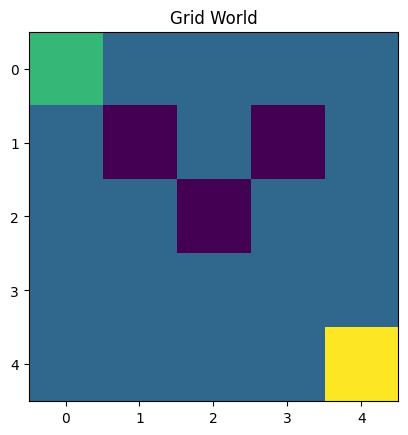

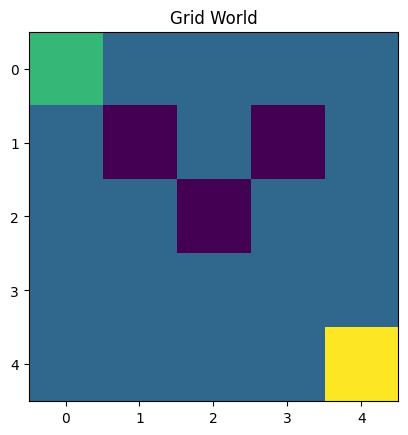

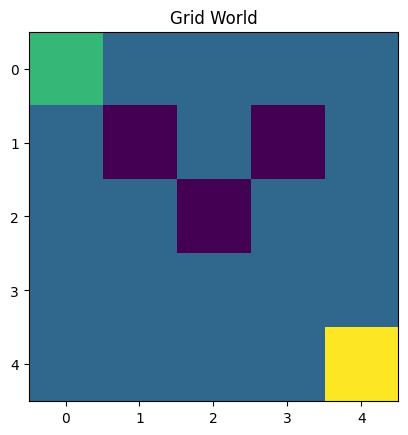

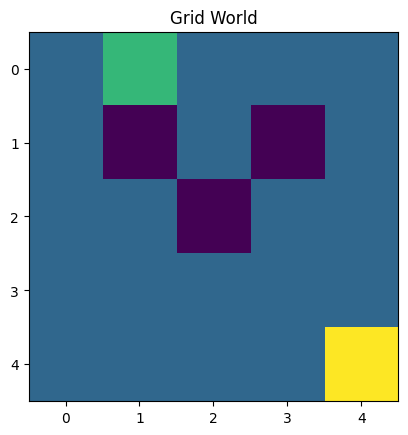

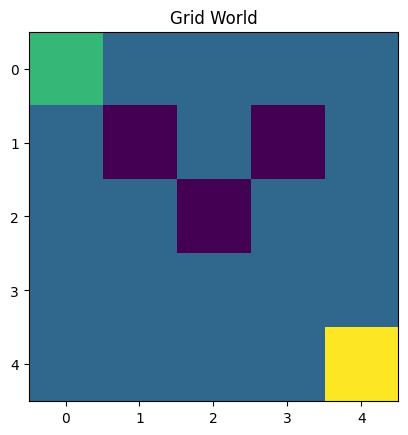

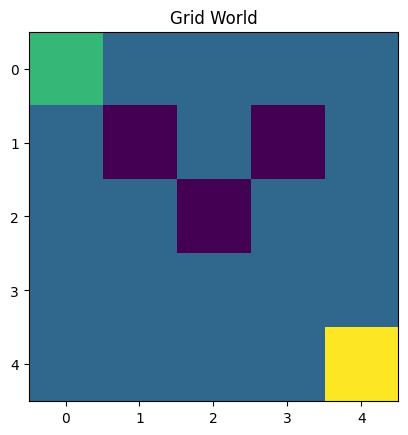

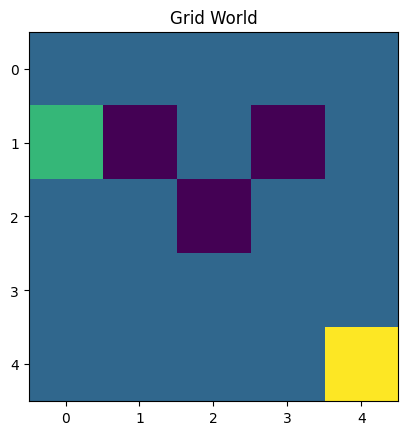

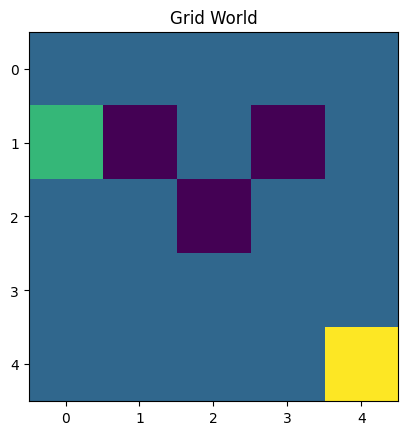

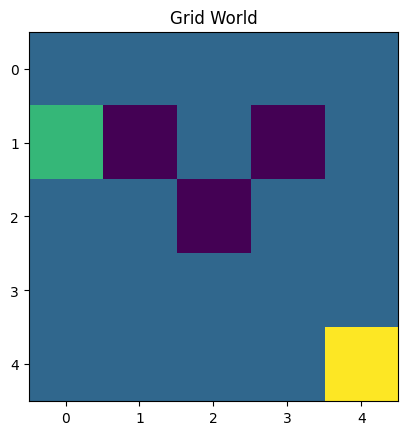

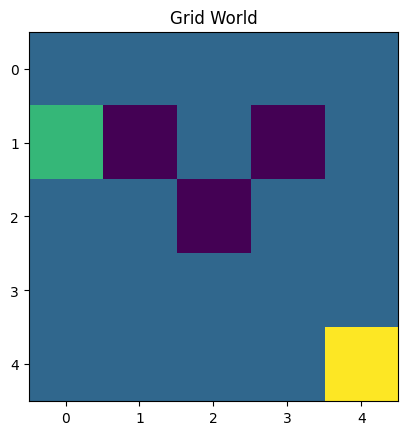

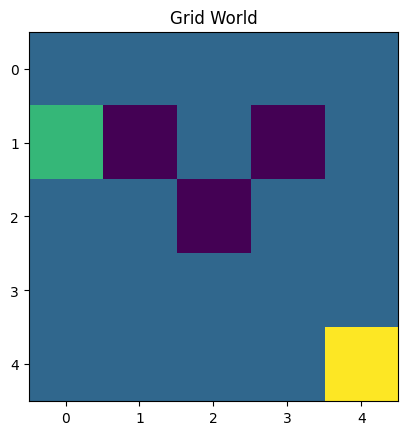

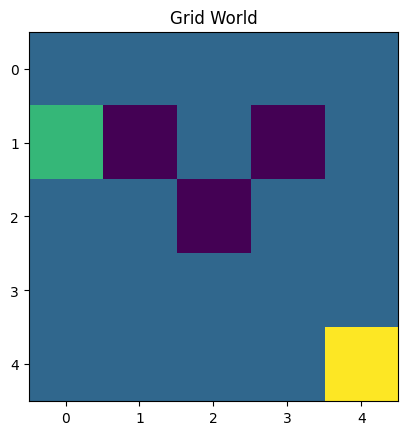

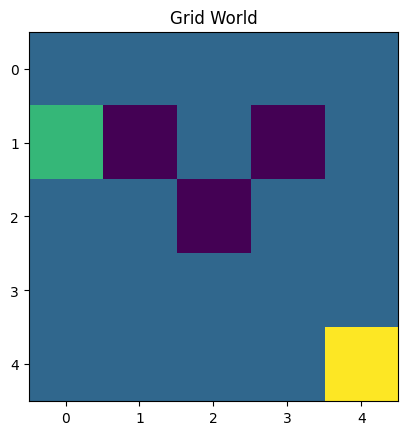

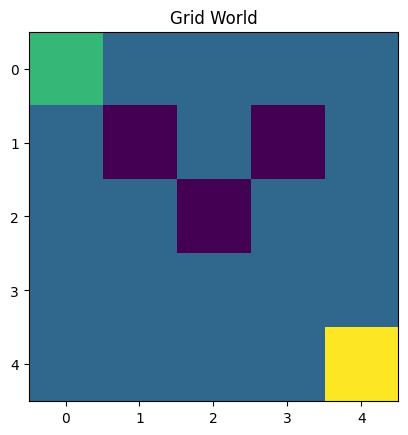

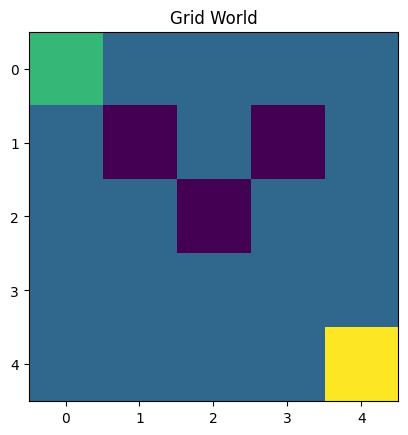

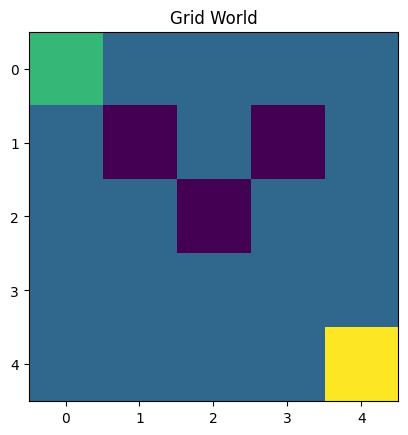

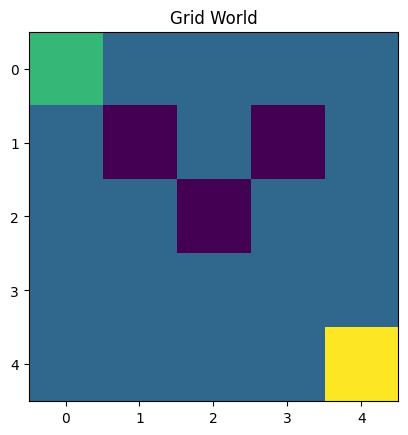

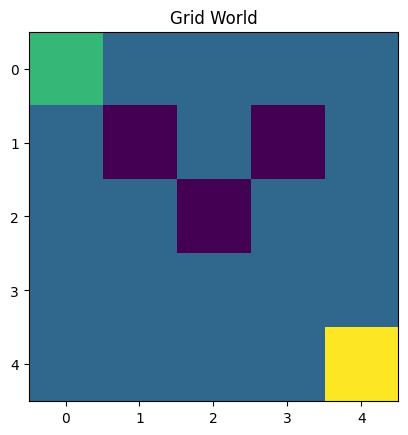

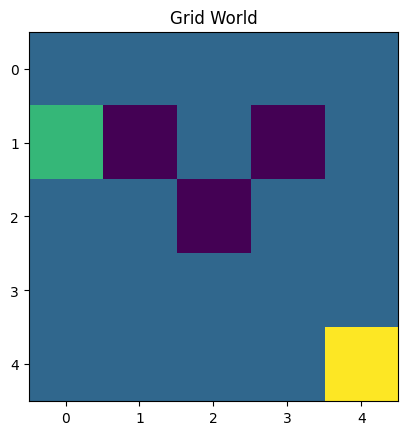

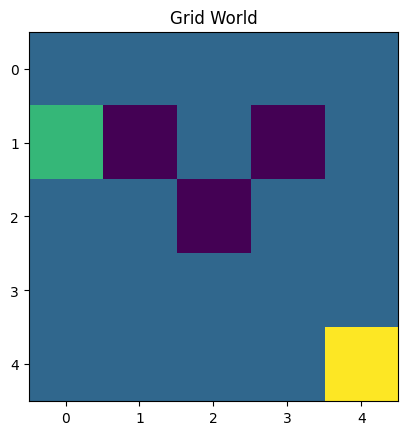

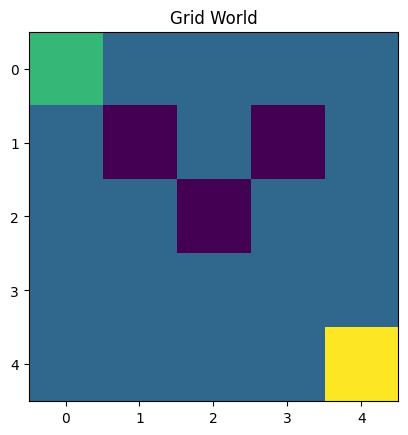

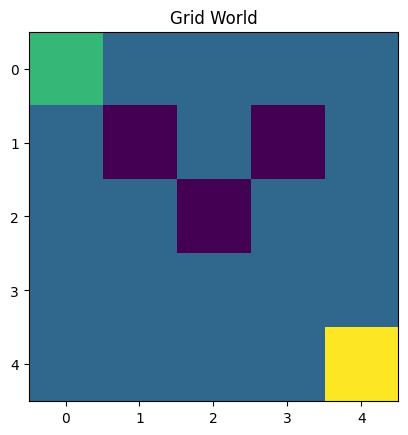

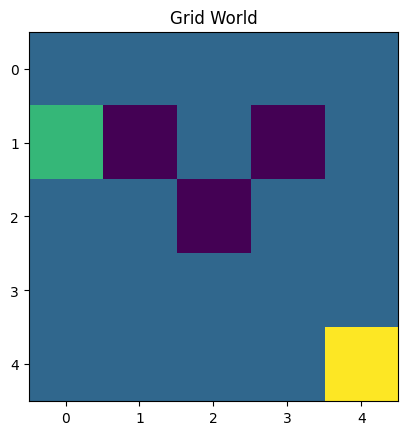

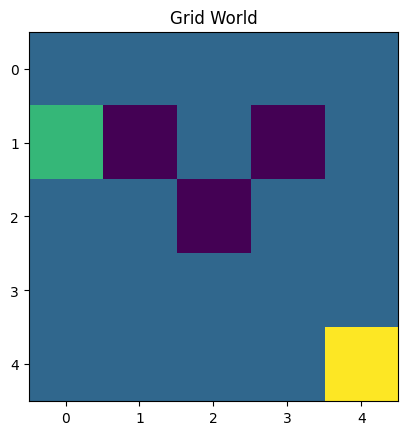

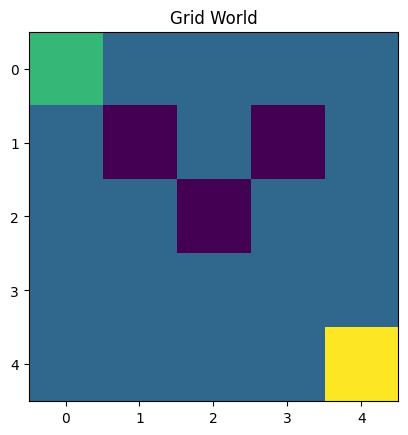

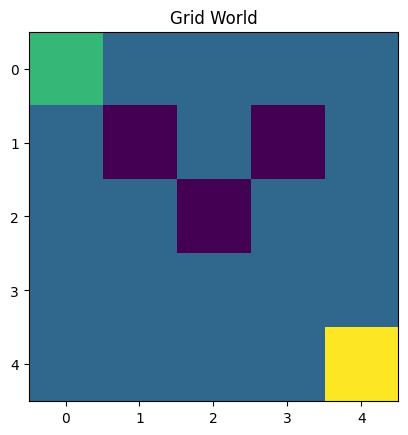

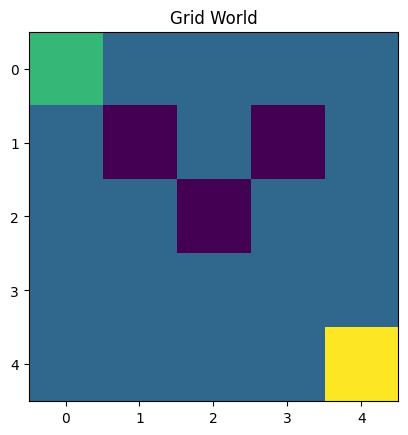

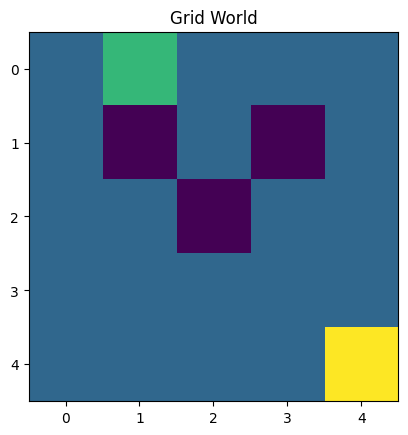

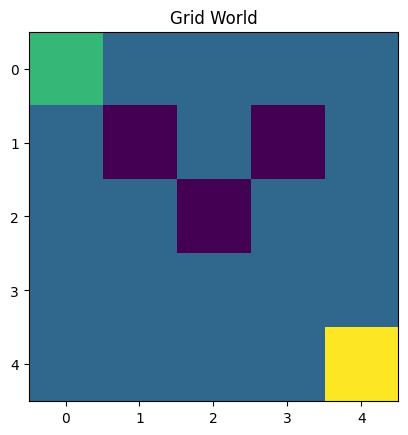

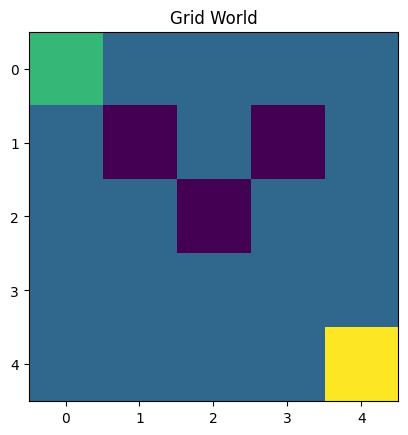

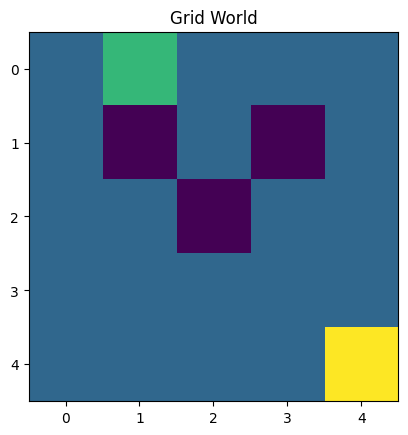

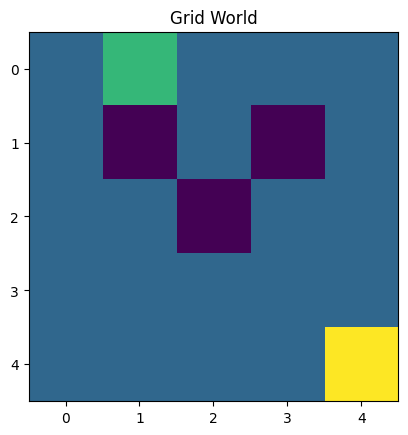

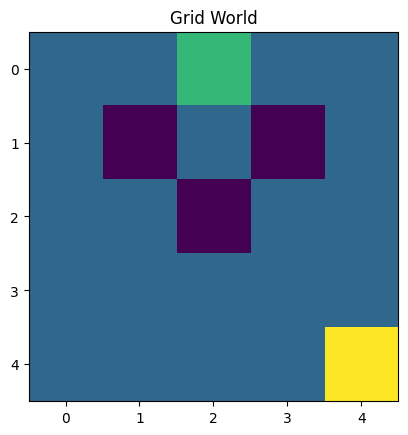

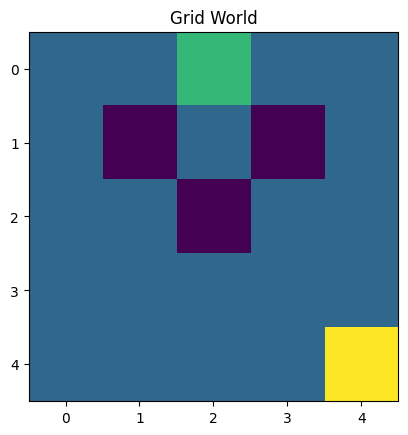

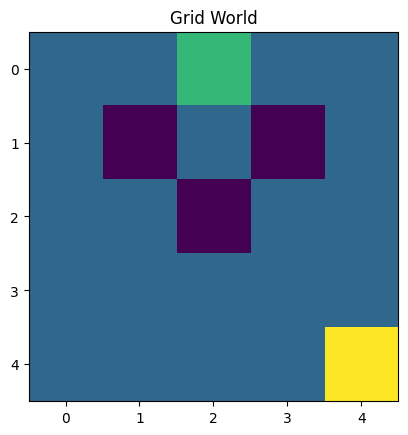

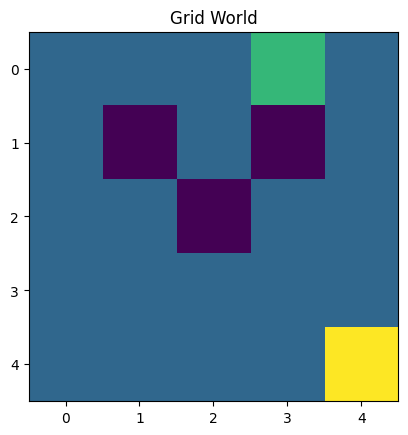

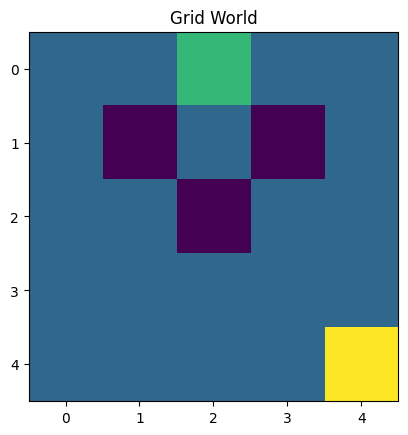

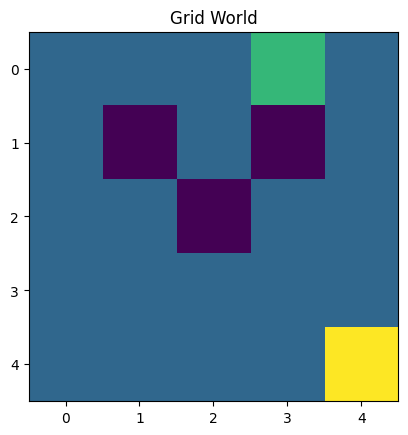

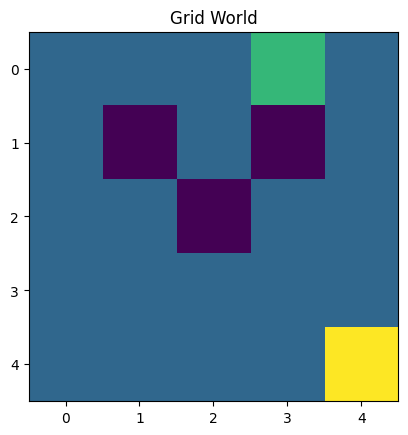

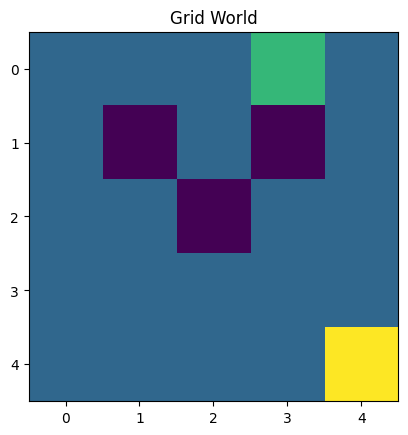

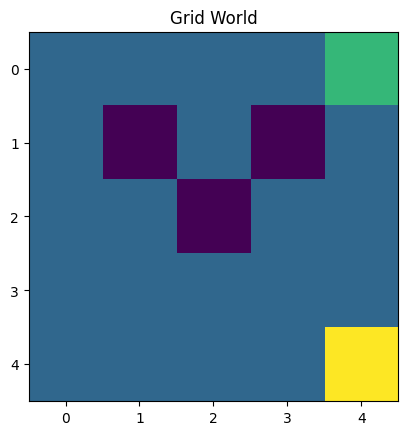

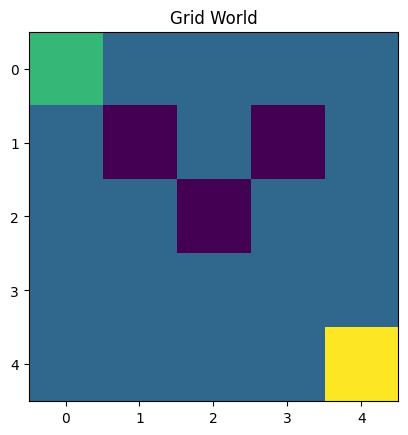

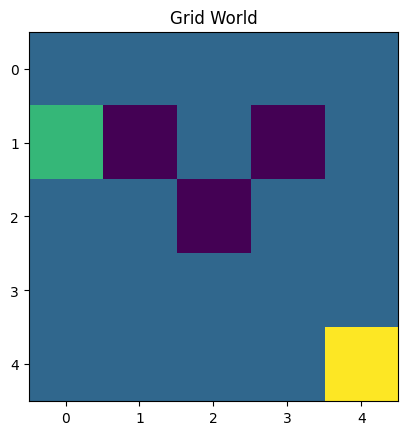

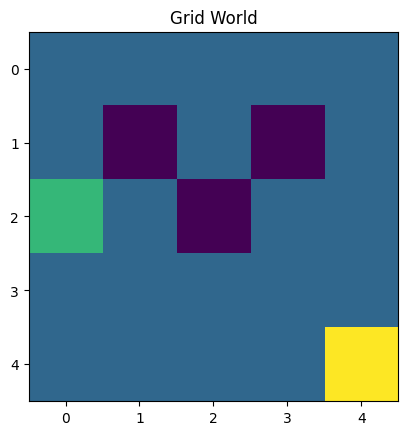

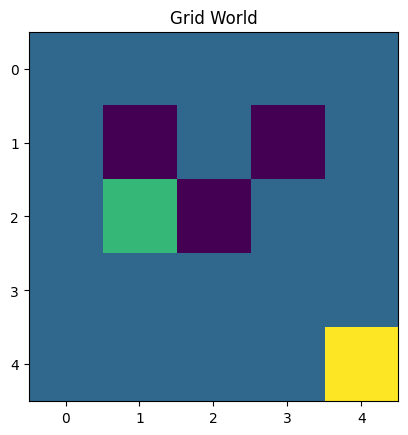

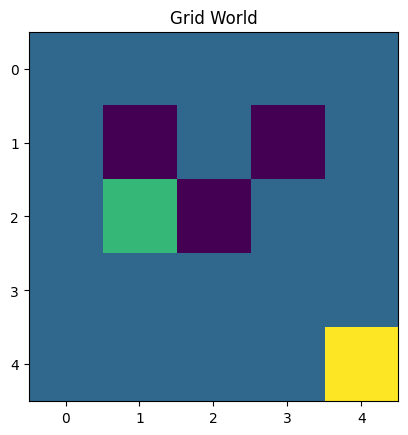

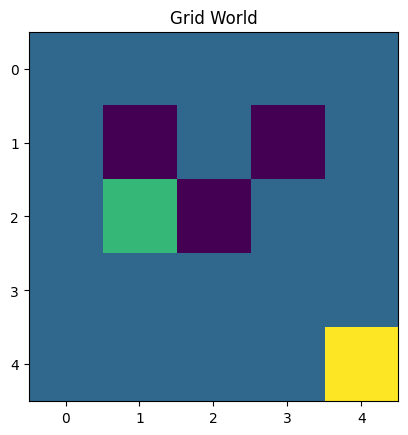

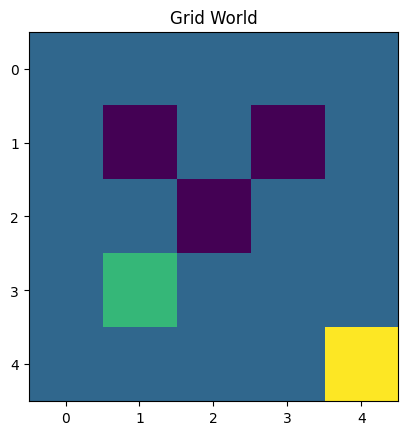

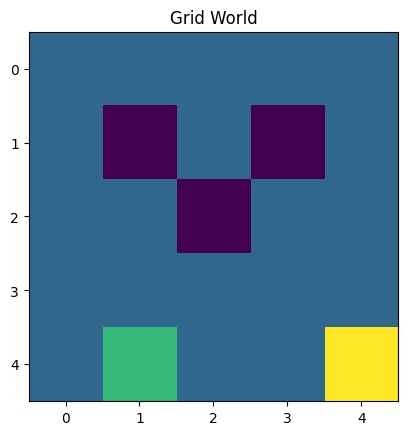

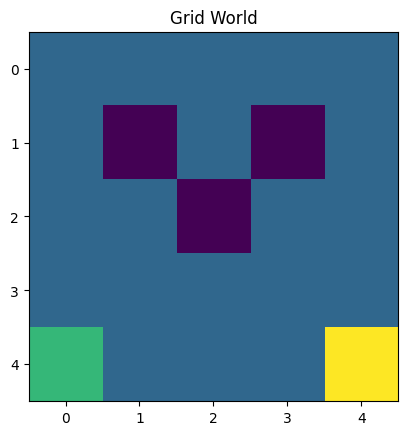

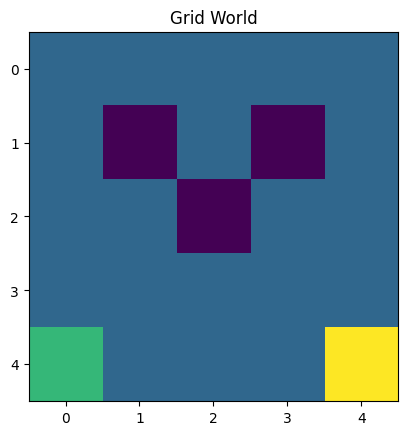

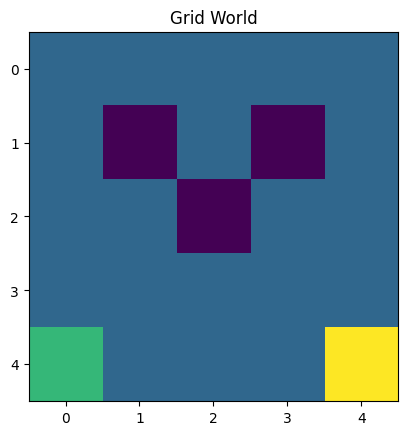

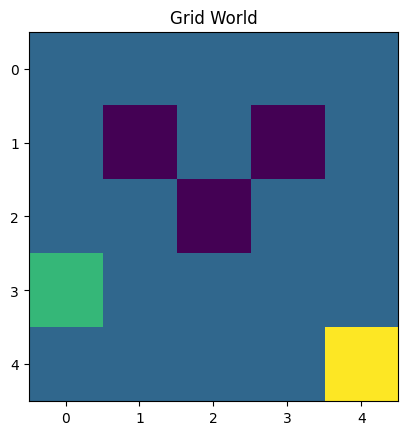

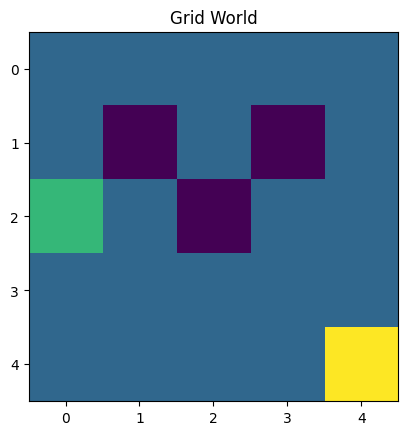

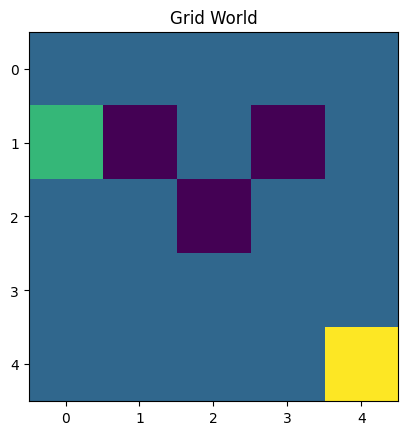

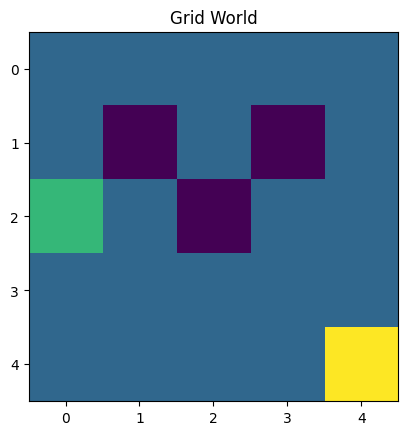

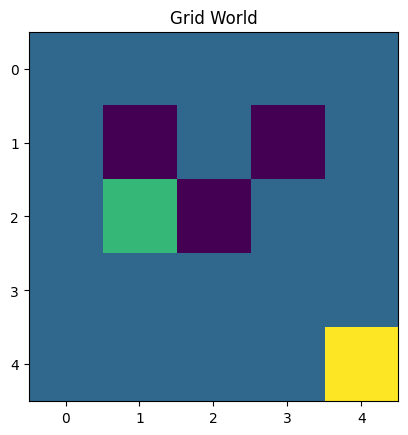

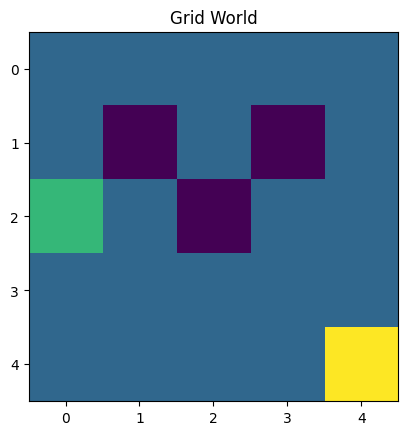

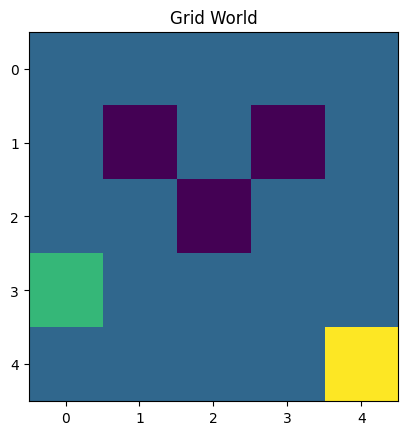

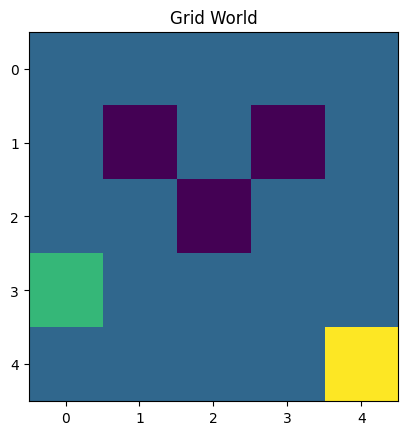

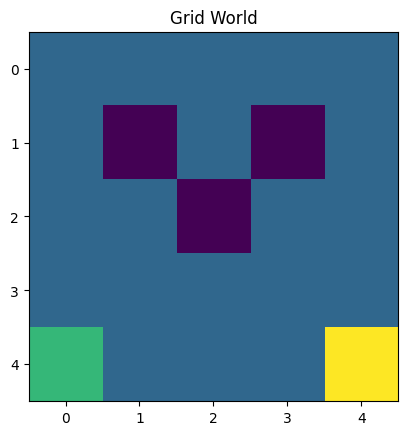

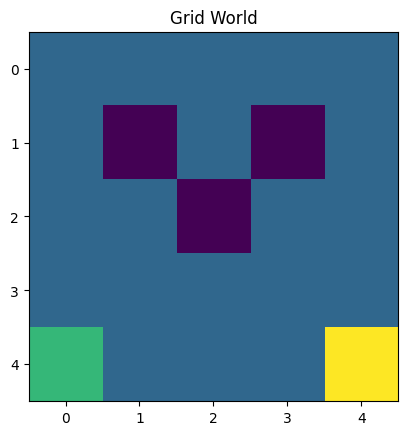

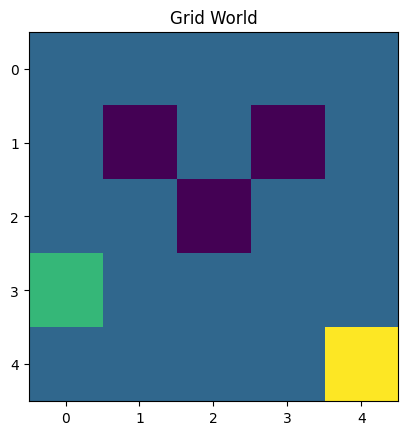

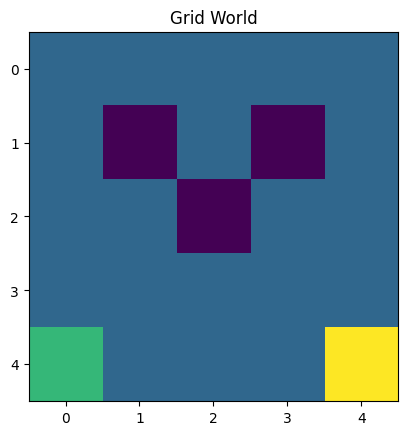

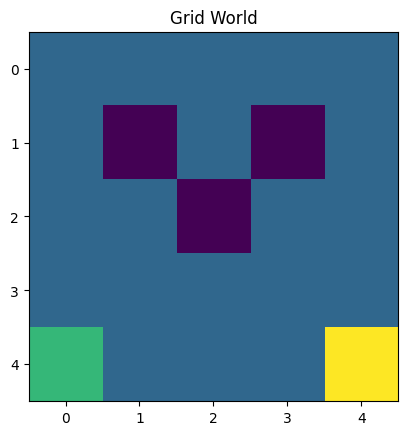

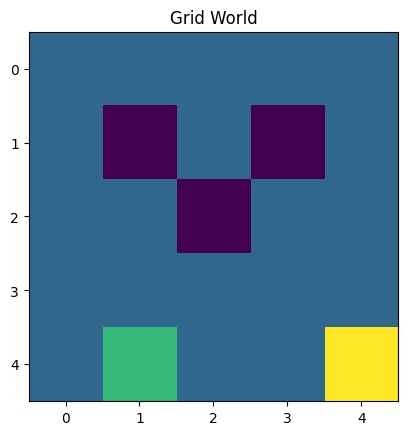

In [ ]:
# Main training loop (with rendering)
max_episodes = 500
max_steps_per_episode = 50

plt.ion() # Turn on interactive mode for plotting

for episode in range(max_episodes):
    states, actions, rewards, values, returns = [], [], [], [], []
    state, _ = env.reset()
    env.render() # Render initial state

    for step in range(max_steps_per_episode):
        state = tf.expand_dims(tf.convert_to_tensor(state, dtype=tf.float32), 0) # Cast to float32
        logits, value = model(state)

        action = tf.random.categorical(logits, 1)[0, 0].numpy()
        next_state, reward, done, _, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        values.append(value)

        state = next_state
        env.render() # Render after each step

        if done:
            # ... (Rest of the episode processing - calculating returns, loss, etc. is the same)
            break

plt.ioff() # Turn off interactive mode
plt.show()